# Определение стоимости автомобилей

Необходимо построить модель для определения стоимости автомобилей на основе исторических данных: технические характеристики, комплектации и цены автомобилей.


Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**<br>
`DateCrawled` — дата скачивания анкеты из базы<br>
`VehicleType` — тип автомобильного кузова<br>
`RegistrationYear` — год регистрации автомобиля<br>
`Gearbox` — тип коробки передач<br>
`Power` — мощность (л. с.)<br>
`Model` — модель автомобиля<br>
`Kilometer` — пробег (км)<br>
`RegistrationMonth` — месяц регистрации автомобиля<br>
`FuelType` — тип топлива<br>
`Brand` — марка автомобиля<br>
`NotRepaired` — была машина в ремонте или нет<br>
`DateCreated` — дата создания анкеты<br>
`NumberOfPictures` — количество фотографий автомобиля<br>
`PostalCode` — почтовый индекс владельца анкеты (пользователя)<br>
`LastSeen` — дата последней активности пользователя<br><br>
**Целевой признак**<br>
`Price` — цена (евро)

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
from sklearn.linear_model import LinearRegression
# import sweetviz as sv
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
%matplotlib inline
import lightgbm
from sklearn.preprocessing import OrdinalEncoder

## Подготовка данных

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv') # чтение файла с данными и сохранение в df0
except:
    data = pd.read_csv('C:\\Users\\User\\Downloads\\autos.csv')

In [3]:
report = sv.analyze([df ,'DF0'])
report.show_html('common analysis.html')

In [4]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Удалим из признаков столбцы 'NumberOfPictures', 'PostalCode', 'Brand', 'DateCrawled', 'RegistrationMonth' т.к. эти данные не нужны при построении моделей.

In [6]:
data = data.drop(columns = ['NumberOfPictures', 'PostalCode', 'Brand', 'DateCrawled', 'RegistrationMonth'], axis=1)

In [7]:
data.duplicated().sum()   # проверка на наличие явных дубликатов

110

In [8]:
df = data.drop_duplicates() # удаление дубликатов

Рассмотрим распределение стоимости автомобилей.

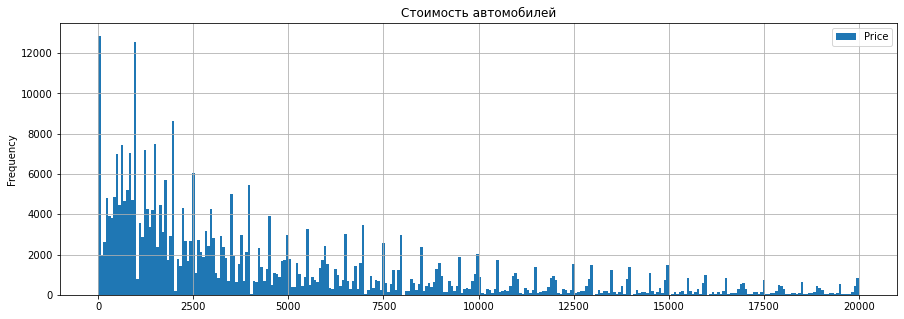

In [9]:
df.plot(kind='hist', y = 'Price',bins=300, grid=True, title='Стоимость автомобилей'
           , xlabel='цена', figsize=(15,5)); # 

В данных есть нулевое значение цены. Удалим эти строки.

In [10]:
df = df[df['Price'] != 0] # удаление аномальных значений цены

Рассмотрим распределение автомоблей по году регистрации.

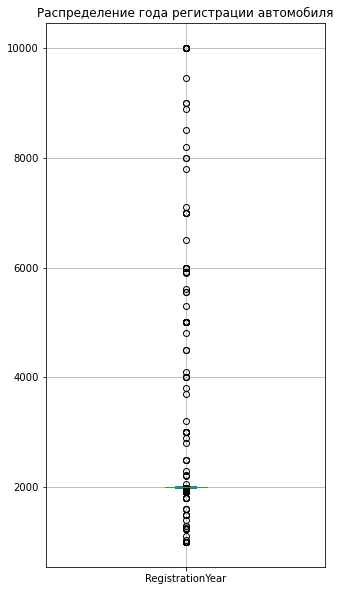

In [11]:
df.plot(kind='box', y='RegistrationYear', grid=True
    , title='Распределение года регистрации автомобиля', figsize=(5,10));

In [12]:
df = df[df['RegistrationYear'] < 2016] # удаление аномальных значений года больше 2016

In [13]:
df = df[df['RegistrationYear'] > 1900] # удаление аномальных значений года меньше 1900

In [14]:
print(df.isna().sum()) # находим количество пропущенных значений

Price                   0
VehicleType         11145
RegistrationYear        0
Gearbox             14367
Power                   0
Model               14429
Kilometer               0
FuelType            20752
NotRepaired         55756
DateCreated             0
LastSeen                0
dtype: int64


In [15]:
df['NotRepaired'].value_counts()

no     233153
yes     31779
Name: NotRepaired, dtype: int64

В столбце NotRepaired 65743 пропущеных значений. Заполним их специальным значением, чтобы не удалять. В остальных столбцах удалим строки с пропущенными значениями.

In [16]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [17]:
df = df.dropna(subset=['VehicleType', 'Gearbox', 'Model', 'FuelType'])

In [18]:
print(df.isna().sum()) # находим количество пропущенных значений

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
NotRepaired         0
DateCreated         0
LastSeen            0
dtype: int64


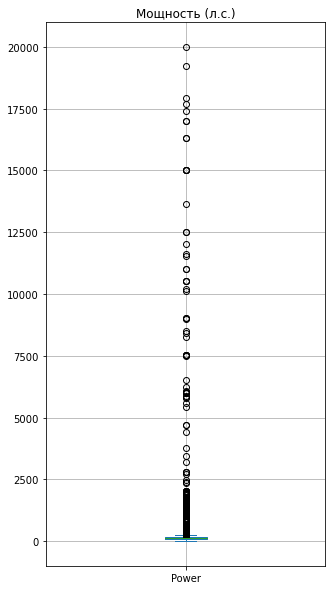

In [19]:
df.plot(kind='box', y='Power', grid=True
    , title='Мощность (л.с.)', figsize=(5,10));

Значение мощности больше двух тысяч лошадных сил являются аномальными. Удалим их.

In [20]:
df = df[df['Power'] < 2000]

Дата создания анкеты и дата последней активности пользователя тоже вряд ли влияют на стоимость автомобиля, поэтому удалим эти столбцы. 

In [21]:
df = df.drop(columns = ['DateCreated', 'LastSeen'], axis=1)

Дубликаты удалены, удалены признаки которые не нужны для построения моделей. Пропущенные и аномальные значения также удалены (примерно 20% данных).

**Кодирование категориальных признаков**

In [22]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,no
5,650,sedan,1995,manual,102,3er,150000,petrol,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,no
...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,petrol,yes
354363,1150,bus,2000,manual,0,zafira,150000,petrol,no
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,no


Для модели lightGBM признаки не кодируем. Переведем категориальные данные в тип "category".

In [23]:
df_for_lgbm = df # сохраним датасэт до кодирования для модели lightGBM

In [24]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
df_for_lgbm[columns] = df_for_lgbm[columns].astype('category')

Для кодирования категориальных признаков для RandomForestRegressor применим порядковое кодирование.

In [25]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,no
5,650,sedan,1995,manual,102,3er,150000,petrol,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,no
...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,petrol,yes
354363,1150,bus,2000,manual,0,zafira,150000,petrol,no
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,no


In [26]:
df_for_tree = df  # сохраним датасэт для кодирования для модели RandomForestRegressor

In [27]:
ord_enc = OrdinalEncoder()

In [28]:
df_for_tree[["VehicleType_code", "Gearbox_code", "Model_code", "FuelType_code", 
             "NotRepaired_code"]] = ord_enc.fit_transform(df_for_tree[["VehicleType", 
                                    "Gearbox","Model", "FuelType", "NotRepaired"]])

In [29]:
df_for_tree = df_for_tree.drop(columns=["VehicleType", "Gearbox","Model", "FuelType", "NotRepaired"])

In [30]:
df_for_tree

,Price,RegistrationYear,Power,Kilometer,VehicleType_code,Gearbox_code,Model_code,FuelType_code,NotRepaired_code
2,9800,2004,163,125000,6.0,0.0,117.0,2.0,1.0
3,1500,2001,75,150000,5.0,1.0,116.0,6.0,0.0
4,3600,2008,69,90000,5.0,1.0,101.0,2.0,0.0
5,650,1995,102,150000,4.0,1.0,11.0,6.0,2.0
6,2200,2004,109,150000,1.0,1.0,8.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225,150000,4.0,1.0,140.0,6.0,2.0
354363,1150,2000,0,150000,0.0,1.0,249.0,6.0,0.0
354366,1199,2000,101,125000,1.0,0.0,106.0,6.0,0.0
354367,9200,1996,102,150000,0.0,1.0,224.0,2.0,0.0


Для кодирования категориальных признаков для линейной регрессии используем one-hot encoding.

In [31]:
df = pd.get_dummies(df,columns=["VehicleType", "Gearbox","Model", "FuelType", "NotRepaired"])

In [32]:
df = df.drop(columns=["VehicleType_code", "Gearbox_code", "Model_code", "FuelType_code", 
             "NotRepaired_code"])

In [33]:
df

,Price,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4,3600,2008,69,90000,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
5,650,1995,102,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
6,2200,2004,109,150000,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
354363,1150,2000,0,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
354366,1199,2000,101,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
354367,9200,1996,102,150000,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


## Обучение моделей

Разделим данные на обучающую и валидационную выборки.

In [34]:
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345)

features_train = df_train.drop(['Price'], axis=1)     # признаки для обучающей выборки                        
target_train = df_train['Price']                      # целевой признак для обучающей выборки   

features_valid = df_valid.drop(['Price'], axis=1)     # признаки для валидационной выборки 
target_valid = df_valid['Price']                      # целевой признак для валидационной выборки 

Для начала обучим константную модель. Для предсказания зададим среднее значение целевого признака Price.

In [35]:
def rmse (features_train, target_train, features_valid, target_valid):
    model = DummyRegressor(strategy="mean").fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions, squared= False)
    return print("RMSE", rmse)

In [36]:
rmse(features_train, target_train, features_valid, target_valid)

RMSE 4644.084625200623


**LinearRegression**

In [37]:
%%time
lr = LinearRegression()
mse_lr = cross_val_score(lr, features_train, target_train, cv=5, scoring='neg_mean_squared_error').mean()

Wall time: 24.8 s


In [38]:
print("RMSE для модели LinearRegression на обучающей выборке:", round(abs(mse_lr)**0.5, 2))

RMSE для модели LinearRegression на обучающей выборке: 2663.48


In [39]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)

Wall time: 5.57 s


LinearRegression()

In [40]:
%%time
predict_lr = lr.predict(features_valid)

Wall time: 246 ms


In [41]:
rmse_lr = mean_squared_error(target_valid, predict_lr, squared= False)
print("RMSE для модели LinearRegression на тестовой выборке:", round(rmse_lr, 2))

RMSE для модели LinearRegression на тестовой выборке: 2678.88


**RandomForestRegressor**

In [42]:
df_train_tree, df_valid_tree = train_test_split(df_for_tree, test_size=0.25, random_state=12345)

features_train_tree = df_train_tree.drop(['Price'], axis=1)     # признаки для обучающей выборки                        
target_train_tree = df_train_tree['Price']                      # целевой признак для обучающей выборки   

features_valid_tree = df_valid_tree.drop(['Price'], axis=1)     # признаки для валидационной выборки 
target_valid_tree = df_valid_tree['Price']                      # целевой признак для валидационной выборки

In [43]:
model_rf =RandomForestRegressor()

In [44]:
parametrs = { 'n_estimators': range (10, 21, 10),   # параметры для поиска лучшей модели
              'max_depth': range (1, 5, 2),
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,5,2),
            }

In [45]:
%%time
grid = GridSearchCV(model_rf, parametrs, cv=5, scoring = 'neg_root_mean_squared_error')   
grid.fit(features_train_tree, target_train_tree)

Wall time: 2min 48s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 5, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5, 2),
                         'n_estimators': range(10, 21, 10)},
             scoring='neg_root_mean_squared_error')

In [46]:
grid.best_params_   # выводим результат с лучшими параметрами

{'max_depth': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 10}

In [47]:
%%time
model_rf = RandomForestRegressor(max_depth = 3,
                                 min_samples_leaf = 4,
                                 min_samples_split = 2,
                                 n_estimators= 10)
mse_rf = cross_val_score(model_rf, features_train_tree, target_train_tree, cv=5, scoring ='neg_mean_squared_error').mean()

Wall time: 5 s


In [48]:
print("RMSE для модели RandomForestRegressor на обучающей выборке:", round(abs(mse_rf)**0.5, 2))

RMSE для модели RandomForestRegressor на обучающей выборке: 2720.19


In [49]:
%%time
model_rf = RandomForestRegressor(random_state=8, max_depth = 3,
                                 min_samples_leaf = 4,
                                 min_samples_split = 2,
                                 n_estimators= 10)
model_rf.fit(features_train_tree, target_train_tree)

Wall time: 1.31 s


RandomForestRegressor(max_depth=3, min_samples_leaf=4, n_estimators=10,
                      random_state=8)

In [50]:
%%time
predict_rf = model_rf.predict(features_valid_tree)

Wall time: 48 ms


In [51]:
rmse = mean_squared_error(target_valid_tree, predict_rf, squared= False)
print("RMSE для модели RandomForestRegressor на тестовой выборке:", round(rmse, 2))

RMSE для модели RandomForestRegressor на тестовой выборке: 2735.74


**LightGBM** 

In [52]:
df_train_gbm, df_valid_gbm = train_test_split(df_for_lgbm, test_size=0.25, random_state=12345)

features_train_gbm = df_train_gbm.drop(['Price'], axis=1)     # признаки для обучающей выборки                        
target_train_gbm = df_train_gbm['Price']                      # целевой признак для обучающей выборки   

features_valid_gbm = df_valid_gbm.drop(['Price'], axis=1)     # признаки для валидационной выборки 
target_valid_gbm = df_valid_gbm['Price']                      # целевой признак для валидационной выборки 

In [53]:
%%time
param_grid = {'learning_rate': [0.2, 0.4, 0.6, 0.8],
              'max_depth': [10, 20, 30, 40],
             }

lgbm = lightgbm.LGBMRegressor()
grid = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0,
                    scoring = 'neg_root_mean_squared_error'
                          )
grid.fit(features_train_gbm, target_train_gbm)
grid.best_params_   # выводим результат с лучшими параметрами

Wall time: 54.1 s


{'learning_rate': 0.2, 'max_depth': 20}

In [54]:
%%time
lgbm = lightgbm.LGBMRegressor(learning_rate = 0.2,
                                 max_depth = 10,
                                )
mse_lgbm = cross_val_score(lgbm, features_train_gbm, target_train_gbm, cv=5, scoring ='neg_mean_squared_error').mean()

Wall time: 7.73 s


In [55]:
print("RMSE для модели LightGBM на обучающей выборке:", round(abs(mse_lgbm)**0.5, 2))

RMSE для модели LightGBM на обучающей выборке: 1572.98


In [56]:
%%time
lgbm = lightgbm.LGBMRegressor(learning_rate = 0.2,
                                 max_depth = 10,
                                )
lgbm.fit(features_train_gbm, target_train_gbm)

Wall time: 1.59 s


LGBMRegressor(learning_rate=0.2, max_depth=10)

In [57]:
%%time
predict_lgbm = lgbm.predict(features_valid_gbm)

Wall time: 345 ms


In [58]:
rmse_gbm = mean_squared_error(target_valid_gbm, predict_lgbm, squared= False)
print("RMSE для модели LightGBM на тестовой выборке:", round(rmse_gbm, 2))

RMSE для модели LightGBM на тестовой выборке: 1575.04


## Анализ моделей

У всех обученных моделей показатель RMSE лучше, чем у константной. Модель LightGBM показывает лучшее значение RMSE и среднее из изученных моделей время обучения и предсказания.

| Имя модели    | RMSE        | Время обучения | Время предсказания
|:------------- |:---------------:| :---------------:|:---------------:|
| LinearRegression      | 2678 | 6.77 s |  225 ms |
| RandomForestRegressor        | 2735        | 1.3 s        |48 ms|
| LightGBM | 1575        | 1.57 s|331 ms|